<a href="https://colab.research.google.com/github/Wk-P/Routing-Monitor-Docker-Request-/blob/main/test_prediction_1_0v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np

# Data preprocessing
file_path = "/content/drive/MyDrive/LSTM/trainingDataSet.txt"
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

name_set = set()
lines = text.split('\n')

training_x = list()
training_y = list()


# create name set
for line in lines:
    matches = re.findall(r"ubuntuDockerWorker(\S+)':", line)
    for match in matches:
        name_set.add(match)

max_node = len(name_set)


for line in lines:
    if len(line) > 1:
        parts = line.split()

        # y training set
        # response worker node number
        training_y.append(str(parts[3]))

        # x training set
        response_time_matches = re.findall(r':\s*([\d.]+)', line)
        cpu_usage_set = [float(match) for match in response_time_matches]
        data = [float(parts[0]), float(parts[2])]
        if max_node > len(cpu_usage_set):
            cpu_usage_set.extend([0 for n in range(0, max_node - len(cpu_usage_set))])
        data.extend(cpu_usage_set)
        training_x.append(data)

training_x = np.array(training_x)
print(training_x)


num_classes = len(set(training_y))
one_hot_encoding = np.eye(num_classes)[[int(label) for label in training_y]]
print(one_hot_encoding)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/LSTM/trainingDataSet.txt'

Epoch 1/10
375/375 [==============================] - 31s 70ms/step - loss: 85.8352 - val_loss: 4.3236
Epoch 2/10
375/375 [==============================] - 26s 70ms/step - loss: 7.1070 - val_loss: 6.1096
Epoch 3/10
375/375 [==============================] - 27s 71ms/step - loss: 8.0987 - val_loss: 7.2860
Epoch 4/10
375/375 [==============================] - 28s 75ms/step - loss: 10.6618 - val_loss: 6.1739
Epoch 5/10
375/375 [==============================] - 27s 72ms/step - loss: 8.0418 - val_loss: 8.0987
Epoch 6/10
375/375 [==============================] - 27s 71ms/step - loss: 2.9776 - val_loss: 1.2327
Epoch 7/10
375/375 [==============================] - 27s 71ms/step - loss: 1.7836 - val_loss: 1.1105
Epoch 8/10
375/375 [==============================] - 27s 72ms/step - loss: 1.4413 - val_loss: 1.1009
Epoch 9/10
375/375 [==============================] - 31s 83ms/step - loss: 1.3838 - val_loss: 1.1013
Epoch 10/10
375/375 [==============================] - 27s 71ms/step - loss: 1.3

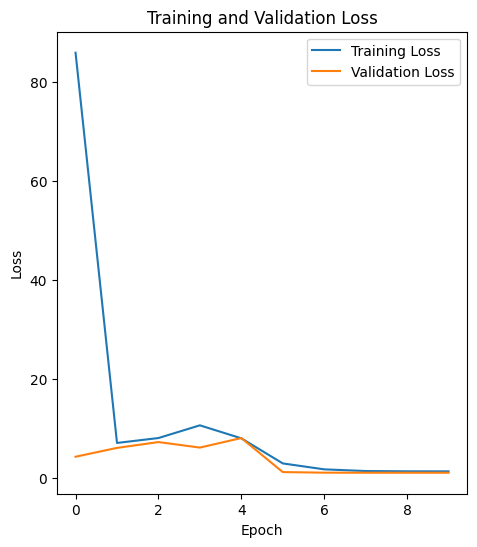

In [20]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

# # Data preprocessing using MinMaxScaler
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

# # Scale features and target variable
# training_x_scaled = scaler_x.fit_transform(np.array(training_x))
# training_y_scaled = scaler_y.fit_transform(np.array(training_y))

def create_sequences(dataset_x, dataset_y, time_steps=1):
    dataX, dataY = [], []
    if len(dataset_x) < time_steps:
        # Handle the case where the input data is smaller than time_steps
        # You can choose to pad the sequence or handle it in a way that makes sense for your data
        # For example, you can replicate the single time step to create a sequence
        x_sequence = np.tile(dataset_x, (time_steps, 1))
        y_target = dataset_y
        dataX.append(x_sequence)
        dataY.append(y_target)
    else:
        for i in range(len(dataset_x) - time_steps + 1):
            x_sequence = dataset_x[i:(i + time_steps), :]
            y_target = dataset_y[i + time_steps - 1, :]
            dataX.append(x_sequence)
            dataY.append(y_target)

    return np.array(dataX), np.array(dataY)

# Create sequences for each set
time_steps = 10
y_classes = len(one_hot_encoding[0])


# Define the split points based on time
train_size = int(len(training_x) * 0.6)
# val_size = int(len(training_x) * 0.3)


# Split the data
x_train = training_x[:train_size]
y_train = one_hot_encoding[:train_size]

x_val = training_x[train_size:]
y_val = one_hot_encoding[train_size:]

# x_test = training_x[train_size:]
# y_test = one_hot_encoding[train_size:]

# Create sequences for each set
x_train_sequences, y_train_sequences = create_sequences(x_train, y_train, time_steps)
x_val_sequences, y_val_sequences = create_sequences(x_val, y_val, time_steps)
# x_test_sequences, y_test_sequences = create_sequences(x_test, y_test, time_steps)


# Initialize LossHistory with validation data
class LossHistory(Callback):
    def __init__(self, x_train, y_train, x_val, y_val):
        super().__init__()
        self.train_data = (x_train, y_train)
        self.validation_data = (x_val, y_val)
        self.losses = []
        self.val_losses = []
        self.train_errors = []
        self.val_errors = []
        self.train_percentage_errors = []
        self.val_percentage_errors = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.val_losses.append(logs.get('val_loss'))

# loop params
LSTM_units = 100
Stop_patience = LSTM_units
Model_epochs = 10
Batch_size = 64
Learning_rate = 0.001

# loss_function = 'mean_squared_error'  # Assuming you are doing regression
loss_function = 'categorical_crossentropy'
# loss_function = 'sparse_categorical_crossentropy'

# Initialize LossHistory with validation data
history = LossHistory(x_train_sequences, y_train_sequences, x_val_sequences, y_val_sequences)


# print(y_train_sequences.shape)

# y_train_flat = y_train_sequences.reshape(-1, y_train_sequences.shape[2])
# y_val_flat = y_val_sequences.reshape(-1, y_val_sequences.shape[2])


# Build LSTM model
model = Sequential()
model.add(LSTM(units=LSTM_units, activation='relu', return_sequences=True, input_shape=(x_train_sequences.shape[1], x_train_sequences.shape[2])))
model.add(Dropout(0.6))

model.add(LSTM(units=LSTM_units, activation='relu', return_sequences=True))

model.add(LSTM(units=LSTM_units, activation='relu'))
model.add(Dropout(0.2))

# model.add(Dense(units=32))

model.add(Dense(units=16))

model.add(Dense(units=y_classes, activation="softmax"))

model.compile(optimizer=Adam(learning_rate=Learning_rate), loss=loss_function)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=Stop_patience, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train_sequences, y_train_sequences, epochs=Model_epochs, batch_size=Batch_size,
          validation_data=(x_val_sequences, y_val_sequences), callbacks=[history, early_stopping])

# model.fit(x_train_sequences, y_train_flat, epochs=Model_epochs, batch_size=Batch_size,
#           validation_data=(x_val_sequences, y_val_flat), callbacks=[history, early_stopping])

# Save the model
# model.save("/content/drive/MyDrive/LSTM/predict_model.keras")

# Plot the training and validation loss and error curves
plt.figure(figsize=(18, 6))

# Plot loss curves
plt.subplot(1, 3, 1)
plt.plot(history.losses, label='Training Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [21]:
import numpy as np
import re
from keras.utils import to_categorical

# Data preprocessing
test_file_path = "/content/drive/MyDrive/LSTM/testDataSet.txt"
with open(file_path, 'r', encoding='utf-8') as f:
    test_text = f.read()

test_name_set = set()
test_lines = test_text.split('\n')

test_x = list()
test_real_y = list()

for line in lines:
    test_matches = re.findall(r"ubuntuDockerWorker(\S+)':", line)
    for match in test_matches:
        test_name_set.add(match)

test_max_node = len(test_name_set)


for line in test_lines:
    if len(line) > 1:
        test_parts = line.split()

        # y training set
        # response worker node number
        test_real_y.append(str(test_parts[3]))

        # x training set
        test_response_time_matches = re.findall(r':\s*([\d.]+)', line)
        test_cpu_usage_set = [float(match) for match in test_response_time_matches]
        test_data = [float(test_parts[0]), float(test_parts[2])]
        if test_max_node > len(test_cpu_usage_set):
            test_cpu_usage_set.extend([0 for n in range(0, test_max_node - len(test_cpu_usage_set))])
        test_data.extend(test_cpu_usage_set)
        test_x.append(test_data)


test_x = np.array(test_x)


test_num_classes = len(set(test_real_y))
test_one_hot_encoding = np.eye(test_num_classes)[[int(label) for label in test_real_y]]

x_test_sequences, y_real_test_sequences = create_sequences(test_x, test_one_hot_encoding, time_steps)


test_y_pred = model.predict(x_test_sequences)


# classified label
predicted_indices = np.argmax(test_y_pred, axis=1)

predicted_indices_one_hot_encoding = to_categorical(predicted_indices)

correct_counter = 0


# result competion
for i in range(len(predicted_indices_one_hot_encoding)):
  for j in range(test_max_node):
    if predicted_indices_one_hot_encoding[i][j] == test_one_hot_encoding[i + 9][j]:
      correct_counter += 1

print(f"accurary: {100 * (correct_counter / 3) / len(test_one_hot_encoding):.2f}%")

1250/1250 [==============================] - 13s 10ms/step
accurary: 56.02%
